#Carga de modulos

In [ ]:
# Data wrangling
import os
import re
import numpy as np
import pandas as pd
from glob import glob
import zipfile
import cv2 # pip install opencv-python
from PIL import Image
import matplotlib.image as mpimg
import plotly.express as px
import shutil
from shutil import copy, rmtree
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Modeling
import tensorflow as tf
#from keras.models import Sequential
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2

# Model performance
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError

In [ ]:
import google.colab
google.colab.drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Definir Rutas

In [ ]:
metadata_path = "/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN 1/metadata.txt"
img_dir = "/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN 1"
train_dir = os.path.join(img_dir, "train")
test_dir = os.path.join(img_dir, "test")
validate_dir = os.path.join(img_dir, "validate")
model_dir = os.path.join(img_dir, "model")

# Lectura de Datos

In [ ]:
metadata = pd.read_csv(metadata_path, sep="|")
print(metadata.head())

    img  n_rooms  n_bathrooms  area  zipcode   price
0  1613        5          3.0  2533    94565  540000
1  1656        3          2.0  1640    93446  425000
2  1580        4          2.0  1881    96019  245000
3  1721        4          3.5  3029    91901  825000
4  1581        2          2.0  1240    92276  117000


In [ ]:
print(metadata.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   img          535 non-null    int64  
 1   n_rooms      535 non-null    int64  
 2   n_bathrooms  535 non-null    float64
 3   area         535 non-null    int64  
 4   zipcode      535 non-null    int64  
 5   price        535 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 25.2 KB
None


In [ ]:
#ver si hay nulos
print(metadata.isnull().sum())

img            0
n_rooms        0
n_bathrooms    0
area           0
zipcode        0
price          0
dtype: int64


In [ ]:
metadata = metadata[["img", "price"]]

In [ ]:
metadata["img"] = metadata["img"].astype(str)
metadata["price"] = metadata["price"].astype(float)

Crear test

In [ ]:
print(f"Total de imágenes en train_dir: {len(os.listdir(train_dir))}")

Total de imágenes en train_dir: 2088


In [ ]:
print(f"Total de imágenes en validate_dir: {len(os.listdir(validate_dir))}")

Total de imágenes en validate_dir: 52


In [ ]:
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Asignar 30%
houses = metadata["img"].unique()
test_houses = np.random.choice(houses, size=int(len(houses) * 0.3), replace=False)

for house_id in test_houses:
    for img_type in ["bathroom", "bedroom", "frontal", "kitchen"]:
        img_name = f"{house_id}_{img_type}.jpg"
        src_path = os.path.join(train_dir, img_name)
        dest_path = os.path.join(test_dir, img_name)
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)

print("División de datos completada")

División de datos completada


In [ ]:
print(f"Total de imágenes en train_dir: {len(os.listdir(train_dir))}")
print(f"Total de imágenes en test_dir: {len(os.listdir(test_dir))}")

Total de imágenes en train_dir: 2088
Total de imágenes en test_dir: 628


# Preparación de imagenes

In [ ]:
def get_image_paths_and_set(house_id):
    paths = {}
    set_type = None

    for img_type in ["bathroom", "bedroom", "kitchen", "frontal"]:
        img_name = f"{house_id}_{img_type}.jpg"
        train_path = os.path.join(train_dir, img_name)
        validate_path = os.path.join(validate_dir, img_name)

        if os.path.exists(train_path):
            paths[f"path_{img_type}"] = train_path
            set_type = "train"
        elif os.path.exists(validate_path):
            paths[f"path_{img_type}"] = validate_path
            set_type = "validate"
        else:
            paths[f"path_{img_type}"] = None

    return pd.Series([paths["path_bathroom"], paths["path_bedroom"],
                      paths["path_kitchen"], paths["path_frontal"], set_type])

In [ ]:
metadata[["path_bathroom", "path_bedroom", "path_kitchen", "path_frontal", "set"]] = metadata["img"].apply(get_image_paths_and_set)
metadata.head()

,img,price,path_bathroom,path_bedroom,path_kitchen,path_frontal,set
0,1613,540000.0,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,train
1,1656,425000.0,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,train
2,1580,245000.0,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,train
3,1721,825000.0,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,train
4,1581,117000.0,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,train


In [ ]:
metadata.value_counts("set")

,count
set,
train,522
validate,13


In [ ]:
def get_image_size(image_path):
    img = cv2.imread(image_path)
    return img.shape

In [ ]:
metadata["size_bathroom"] = metadata["path_bathroom"].apply(get_image_size)
metadata["size_bedroom"] = metadata["path_bedroom"].apply(get_image_size)
metadata["size_kitchen"] = metadata["path_kitchen"].apply(get_image_size)
metadata["size_frontal"] = metadata["path_frontal"].apply(get_image_size)
metadata.head()

,img,price,path_bathroom,path_bedroom,path_kitchen,path_frontal,set,size_bathroom,size_bedroom,size_kitchen,size_frontal
0,1613,540000.0,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,train,"(683, 1024, 3)","(683, 1024, 3)","(683, 1024, 3)","(683, 1024, 3)"
1,1656,425000.0,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,train,"(512, 767, 3)","(512, 767, 3)","(512, 767, 3)","(512, 767, 3)"
2,1580,245000.0,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,train,"(767, 511, 3)","(683, 1024, 3)","(683, 1024, 3)","(576, 1024, 3)"
3,1721,825000.0,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,train,"(682, 1024, 3)","(682, 1024, 3)","(683, 1024, 3)","(682, 1024, 3)"
4,1581,117000.0,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,train,"(573, 1020, 3)","(573, 1020, 3)","(573, 1020, 3)","(573, 1020, 3)"


In [ ]:
metadata.shape

(535, 11)

# Visualización

In [ ]:
def visualize_random_houses(metadata, num_houses=4):
    sampled_houses = metadata.sample(n=num_houses, random_state=42)
    fig, axes = plt.subplots(num_houses, 4, figsize=(12, 12))
    fig.suptitle("Muestra de Casas Aleatorias", fontsize=16)

    for i, (_, row) in enumerate(sampled_houses.iterrows()):
        house_id = row["img"]
        image_paths = {
            "Bathroom": row["path_bathroom"],
            "Bedroom": row["path_bedroom"],
            "Kitchen": row["path_kitchen"],
            "Frontal": row["path_frontal"],
        }

        for j, (title, path) in enumerate(image_paths.items()):
            ax = axes[i, j]
            if path and os.path.exists(path):
                img = cv2.imread(path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax.imshow(img)
            else:
                ax.set_facecolor("gray")
                ax.text(0.5, 0.5, "No Image", ha="center", va="center", fontsize=12)

            if i == 0:
                ax.set_title(title, fontsize=14)

            ax.axis("off")

        axes[i, 0].text(-0.5, 0.5, f"House: {house_id}", va="center", ha="right",
                        fontsize=12, fontweight="bold", transform=axes[i, 0].transAxes)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92, left=0.15)
    plt.show()

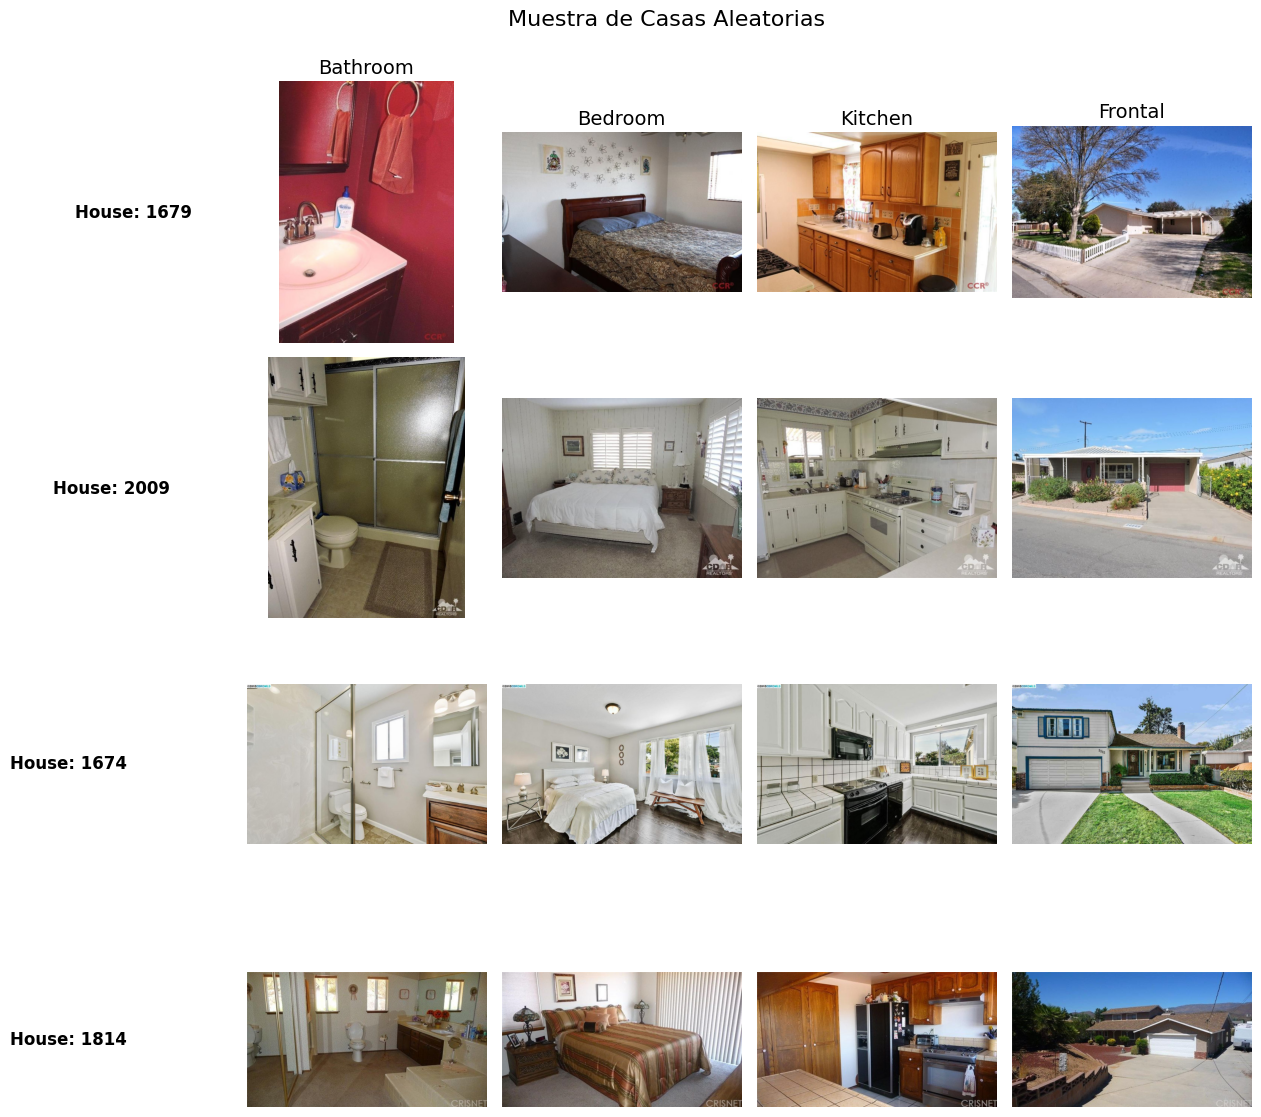

In [ ]:
visualize_random_houses(metadata)

In [ ]:
train_folder = os.path.join(img_dir, "train_img")
validate_folder = os.path.join(img_dir, "validate_img")

In [ ]:
os.makedirs(train_folder, exist_ok=True)
os.makedirs(validate_folder, exist_ok=True)

In [ ]:
def concatenate_and_save_images(row, target_size=(128, 128)):
    images = []
    for col in ["path_bathroom", "path_bedroom", "path_kitchen", "path_frontal"]:
        img_path = row[col]
        if pd.isna(img_path) or not os.path.exists(img_path):
            img = np.zeros((*target_size, 3), dtype=np.uint8)
        else:
            img = cv2.imread(img_path)
            img = cv2.resize(img, target_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

    top_row = np.concatenate(images[:2], axis=1)
    bottom_row = np.concatenate(images[2:], axis=1)
    concat_image = np.concatenate([top_row, bottom_row], axis=0)

    set_folder = train_folder if row["set"] == "train" else validate_folder
    img_filename = os.path.join(set_folder, f"{row['img']}.jpg")

    success = cv2.imwrite(img_filename, cv2.cvtColor(concat_image, cv2.COLOR_RGB2BGR))
    if not success:
        print(f"No se pudo guardar la imagen: {img_filename}")

    return img_filename

In [ ]:
metadata["path_img"] = metadata.apply(concatenate_and_save_images, axis=1)

In [ ]:
metadata["size_path_img"] = metadata["path_img"].apply(get_image_size)

In [ ]:
metadata

,img,price,path_bathroom,path_bedroom,path_kitchen,path_frontal,set,size_bathroom,size_bedroom,size_kitchen,size_frontal,path_img,size_path_img
0,1613,540000.0,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,train,"(683, 1024, 3)","(683, 1024, 3)","(683, 1024, 3)","(683, 1024, 3)",/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,"(256, 256, 3)"
1,1656,425000.0,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,train,"(512, 767, 3)","(512, 767, 3)","(512, 767, 3)","(512, 767, 3)",/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,"(256, 256, 3)"
2,1580,245000.0,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,train,"(767, 511, 3)","(683, 1024, 3)","(683, 1024, 3)","(576, 1024, 3)",/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,"(256, 256, 3)"
3,1721,825000.0,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,train,"(682, 1024, 3)","(682, 1024, 3)","(683, 1024, 3)","(682, 1024, 3)",/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,"(256, 256, 3)"
4,1581,117000.0,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,train,"(573, 1020, 3)","(573, 1020, 3)","(573, 1020, 3)","(573, 1020, 3)",/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,"(256, 256, 3)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,2051,1150000.0,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,train,"(678, 1024, 3)","(678, 1024, 3)","(678, 1024, 3)","(678, 1024, 3)",/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,"(256, 256, 3)"
531,1685,668000.0,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,train,"(682, 1024, 3)","(682, 1024, 3)","(354, 1024, 3)","(682, 1024, 3)",/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,"(256, 256, 3)"
532,1883,4000000.0,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,train,"(679, 1020, 3)","(679, 1020, 3)","(679, 1020, 3)","(679, 1020, 3)",/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,"(256, 256, 3)"
533,1533,179000.0,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,train,"(575, 767, 3)","(575, 767, 3)","(575, 767, 3)","(575, 767, 3)",/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN...,"(256, 256, 3)"


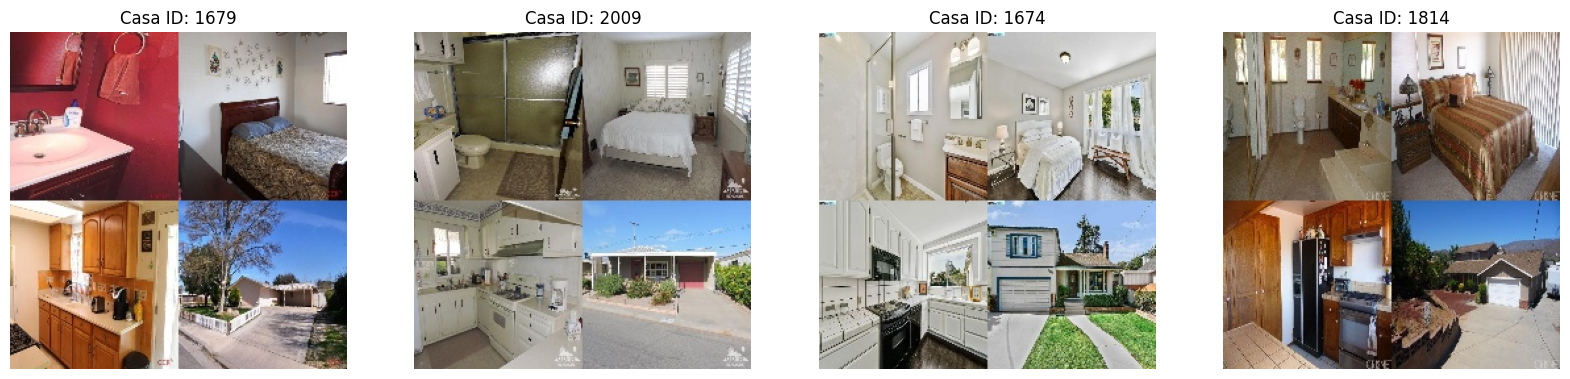

In [ ]:
def visualizar_path_img(metadata, num_muestras=4):
    muestras = metadata.sample(num_muestras, random_state=42)

    fig, axes = plt.subplots(1, num_muestras, figsize=(20, 20))

    for i, (idx, row) in enumerate(muestras.iterrows()):
        img_path = row["path_img"]
        house_id = row["img"]

        if not os.path.exists(img_path):
            print(f"Imagen no encontrada: {img_path}")
            continue

        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Casa ID: {house_id}", fontsize=12)
        axes[i].axis("off")

    plt.show()

visualizar_path_img(metadata)

In [ ]:
metadata = metadata[metadata["set"] != "validate"]

In [ ]:
metadata.shape

(522, 13)

In [ ]:
fig = px.histogram(metadata, x="price", nbins=50, title="Distribución de Precios")
fig.show()

In [ ]:
fig = px.box(metadata, y="price", title="Boxplot de Precios")
fig.show()

In [ ]:
def eliminar_outliers_iqr(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.90)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df_filtrado = df[(df[columna] >= limite_inferior) & (df[columna] <= limite_superior)]
    return df_filtrado
metadata = eliminar_outliers_iqr(metadata, 'price')

In [ ]:
lower_percentile = metadata['price'].quantile(0.10)
upper_percentile = metadata['price'].quantile(0.90)

metadata['price'] = metadata['price'].clip(lower_percentile, upper_percentile)

<ipython-input-28-3fd670624eec>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
robust_scaler = RobustScaler()
metadata["price"] = robust_scaler.fit_transform(metadata[["price"]])

<ipython-input-28-3b0df95b97f7>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
print(metadata["price"].describe())

count    519.000000
mean       0.073367
std        0.847311
min       -1.052744
25%       -0.597480
50%        0.000000
75%        0.402520
max        3.568225
Name: price, dtype: float64


In [ ]:
metadata.isnull().sum()

,0
img,0
price,0
path_bathroom,0
path_bedroom,0
path_kitchen,0
path_frontal,0
set,0
size_bathroom,0
size_bedroom,0
size_kitchen,0


In [ ]:
metadata.shape

(519, 13)

In [ ]:
for img_path in metadata["path_img"].sample(5):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Imagen no encontrada: {img_path}")
    else:
        print(img.shape)

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


# Generadores

In [ ]:
dgen_train = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

In [ ]:
dgen_validation = ImageDataGenerator(rescale=1./255)

In [ ]:
dgen_test = ImageDataGenerator(rescale=1./255)

In [ ]:
TARGET_SIZE = (256, 256)
BATCH_SIZE = 30
CLASS_MODE = 'raw'

## TRAIN TES SPLIT

In [ ]:
train = metadata.loc[metadata["set"] == "train"].copy()
validate = metadata.loc[metadata["set"] == "validate"].copy()

In [ ]:
train_generator = dgen_train.flow_from_dataframe(dataframe=train,
                                                 x_col="path_img",
                                                 y_col="price",
                                                 class_mode=CLASS_MODE,
                                                 subset="training",
                                                 target_size=TARGET_SIZE,
                                                 batch_size=BATCH_SIZE)

Found 416 validated image filenames.


In [ ]:
test_generator = dgen_train.flow_from_dataframe(dataframe=train,
                                                x_col="path_img",
                                                y_col="price",
                                                class_mode=CLASS_MODE,
                                                subset="validation",
                                                target_size=TARGET_SIZE,
                                                batch_size=BATCH_SIZE)

Found 103 validated image filenames.


In [ ]:
val_generator = dgen_validation.flow_from_dataframe(dataframe=validate,
                                               x_col="path_img",
                                               y_col="price",
                                               class_mode=CLASS_MODE,
                                               target_size=TARGET_SIZE)
                                               #batch_size=BATCH_SIZE)

In [ ]:
train_generator.image_shape

(512, 512, 3)

# Modelo

In [ ]:
model = Sequential()

## Capas convolucionales

In [ ]:
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

'''model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))'''

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



"model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D((2, 2)))\nmodel.add(Dropout(0.5))\n\nmodel.add(Conv2D(128, (3, 3), padding='same', activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D((2, 2)))\nmodel.add(Dropout(0.4))\n\nmodel.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D((2, 2)))\nmodel.add(Dropout(0.4))\n\nmodel.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D((2, 2)))\nmodel.add(Dropout(0.5))"

## Capas densas

In [ ]:
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer="l2"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 524288)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      33,554,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,564,737 (128.04 MB)

 Trainable params: 33,564,289 (128.04 MB)

 Non-trainable params: 448 (1.75 KB)

# Entrenamiento

## Configuración de entrenamiento

In [ ]:
os.makedirs(model_dir, exist_ok=True)

### metricas

In [ ]:
kmetrics = [
    RootMeanSquaredError(name='rms'),
    MeanAbsoluteError(name='mae'),
    MeanAbsolutePercentageError(name='mape')
]

In [ ]:
model.compile(Adam(learning_rate=0.0001), loss="mse", metrics=kmetrics)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10)
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mape', patience=10, restore_best_weights=True)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN 1/model/model_{val_mae:.3f}.keras',
                                             save_best_only=True,
                                             save_weights_only=False,
                                             monitor='val_mae')

### Entrenamiento

In [ ]:
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=test_generator,
                    callbacks=[early_stopping, checkpoint])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 92s 6s/step - loss: 5.7488 - mae: 1.6997 - mape: 17448872.0000 - rms: 2.1131 - val_loss: 2.2430 - val_mae: 0.8638 - val_mape: 882.0212 - val_rms: 1.0211
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - loss: 4.5544 - mae: 1.4613 - mape: 15363447.0000 - rms: 1.8338 - val_loss: 2.0578 - val_mae: 0.8053 - val_mape: 750.4556 - val_rms: 0.9436
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - loss: 4.8905 - mae: 1.5337 - mape: 5807471.5000 - rms: 1.9265 - val_loss: 1.8788 - val_mae: 0.6765 - val_mape: 393.8214 - val_rms: 0.8481
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - loss: 4.3463 - mae: 1.4351 - mape: 15115536.0000 - rms: 1.7835 - val_loss: 1.8081 - val_mae: 0.6154 - val_mape: 223.8609 - val_rms: 0.8073
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 80s 6s/step - loss: 3.9644 - mae: 1.3420 - mape: 7417281.0000 - rms: 1.6754 - val_loss: 1.7643 - val_mae: 0.5759 - val_mape: 209.5206 - val_rms: 0.7810
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 77

#Evaluación

In [ ]:
results = pd.DataFrame(history.history)

In [ ]:
results

,loss,mae,mape,rms,val_loss,val_mae,val_mape,val_rms
0,5.305390,1.600598,14229083.0,2.015143,2.242964,0.863755,882.021179,1.021055
1,4.540301,1.489449,13558719.0,1.832691,2.057835,0.805338,750.455566,0.943635
2,4.481747,1.433204,12932066.0,1.821765,1.878848,0.676518,393.821381,0.848104
3,4.444480,1.444169,11679084.0,1.812909,1.808084,0.615435,223.860916,0.807338
4,3.977379,1.331159,13548793.0,1.679893,1.764327,0.575920,209.520630,0.780990
5,3.766355,1.301994,10805420.0,1.616344,1.775632,0.575072,368.778076,0.789054
6,3.979797,1.330678,12234837.0,1.681549,1.774571,0.569896,336.448639,0.789343
7,3.994328,1.328637,6914310.0,1.686057,1.777677,0.566145,369.628235,0.791207
8,4.392173,1.408904,9830929.0,1.800021,1.807840,0.588539,401.385284,0.809287
9,4.104027,1.322774,5935234.0,1.717681,1.804822,0.586824,307.829315,0.806560


In [ ]:
results['epochs'] = results.index
fig = px.line(results, x='epochs', y=results.columns[:-1], title="Evolución del entrenamiento", labels={'value': 'Métrica', 'epoch': 'Épocas'})
fig.show()

#Predicción

In [ ]:
model_dir = '/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN 1/model/'
model_files = [f for f in os.listdir(model_dir) if f.endswith('.keras')]

if not model_files:
    raise FileNotFoundError("No se encontraron archivos .keras en el directorio del modelo.")

best_model_file = None
best_val_mape = float('inf')

for file in model_files:
    match = re.search(r'model_([\d.]+)%.keras', file)
    if match:
        val_mape = float(match.group(1))
        if val_mape < best_val_mape:
            best_val_mape = val_mape
            best_model_file = file

if best_model_file:
    best_model_path = os.path.join(model_dir, best_model_file)
    print(f"Mejor modelo encontrado: {best_model_path}")
else:
    raise FileNotFoundError("No se pudo encontrar un modelo con val_mape en el nombre.")

**Usando el modelo con menor mae**

In [ ]:
model_dir = '/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN 1/model/'

model_files = [f for f in os.listdir(model_dir) if f.endswith('.keras')]

if not model_files:
    raise FileNotFoundError("No se encontraron archivos .keras en el directorio del modelo.")

best_model_file = None
best_val_mae = float('inf')

for file in model_files:
    match = re.search(r'model_([\d.]+)\.keras', file)
    if match:
        val_mae = float(match.group(1))
        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_model_file = file

if best_model_file:
    best_model_path = os.path.join(model_dir, best_model_file)
    print(f"Mejor modelo encontrado: {best_model_path}")
else:
    raise FileNotFoundError("No se pudo encontrar un modelo con val_mae en el nombre.")

Mejor modelo encontrado: /content/drive/MyDrive/Apuntes Modulo 4/EXAMEN 1/model/model_0.472.keras


In [ ]:
# Preparar las imágenes de validación
validate_img_dir = '/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN 1/validate_img'
image_files = os.listdir(validate_img_dir)
image_paths = [os.path.join(validate_img_dir, file) for file in image_files if file.endswith('.jpg')]
model = tf.keras.models.load_model(best_model_path)

images = []
for path in image_paths:
    img = cv2.imread(path)
    img = cv2.resize(img, (256, 256)) #TARGET_SIZE
    img = img / 255.0
    images.append(img)

images = np.array(images)

# Realizar las predicciones
predictions = model.predict(images)

predicted_prices_scaled = predictions.flatten()
predicted_prices = robust_scaler.inverse_transform(predicted_prices_scaled.reshape(-1, 1)).flatten()

for i, file_name in enumerate(image_files):
    print(f"Imagen: {file_name}, Precio Predicho: {predicted_prices[i]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step
Imagen: 1904.jpg, Precio Predicho: 463766.91
Imagen: 2014.jpg, Precio Predicho: 386800.53
Imagen: 1707.jpg, Precio Predicho: 474288.56
Imagen: 1771.jpg, Precio Predicho: 380875.03
Imagen: 1608.jpg, Precio Predicho: 413875.88
Imagen: 1603.jpg, Precio Predicho: 595130.69
Imagen: 1859.jpg, Precio Predicho: 501495.19
Imagen: 2035.jpg, Precio Predicho: 513933.16
Imagen: 1848.jpg, Precio Predicho: 408844.69
Imagen: 1583.jpg, Precio Predicho: 478944.62
Imagen: 1742.jpg, Precio Predicho: 397823.84
Imagen: 1989.jpg, Precio Predicho: 434452.19
Imagen: 2018.jpg, Precio Predicho: 527815.88


**Usando el modelo de 0.540**

In [ ]:
# Preparar las imágenes de validación
best_model_path='/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN 1/model/model_0.540.keras'
validate_img_dir = '/content/drive/MyDrive/Apuntes Modulo 4/EXAMEN 1/validate_img'
image_files = os.listdir(validate_img_dir)
image_paths = [os.path.join(validate_img_dir, file) for file in image_files if file.endswith('.jpg')]
model = tf.keras.models.load_model(best_model_path)

images = []
for path in image_paths:
    img = cv2.imread(path)
    img = cv2.resize(img, (256, 256)) #TARGET_SIZE
    img = img / 255.0
    images.append(img)

images = np.array(images)

# Realizar las predicciones
predictions = model.predict(images)

predicted_prices_scaled = predictions.flatten()
predicted_prices = robust_scaler.inverse_transform(predicted_prices_scaled.reshape(-1, 1)).flatten()

for i, file_name in enumerate(image_files):
    print(f"Imagen: {file_name}, Precio Predicho: {predicted_prices[i]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Imagen: 1904.jpg, Precio Predicho: 354382.38
Imagen: 2014.jpg, Precio Predicho: 417433.91
Imagen: 1707.jpg, Precio Predicho: 468980.75
Imagen: 1771.jpg, Precio Predicho: 320806.81
Imagen: 1608.jpg, Precio Predicho: 458088.69
Imagen: 1603.jpg, Precio Predicho: 381643.38
Imagen: 1859.jpg, Precio Predicho: 389998.31
Imagen: 2035.jpg, Precio Predicho: 390094.94
Imagen: 1848.jpg, Precio Predicho: 407679.25
Imagen: 1583.jpg, Precio Predicho: 390872.41
Imagen: 1742.jpg, Precio Predicho: 304704.50
Imagen: 1989.jpg, Precio Predicho: 424547.59
Imagen: 2018.jpg, Precio Predicho: 269393.03
